# RL Basics

## Background: REINFORCE

Loss $l(f_\theta(x)) = \left(10 - \lvert f_\theta(x)\rvert\right)^2$ is non-differentiable, $x$ is a sentence, $\theta$ are model weights. Objective:

$$\min_\theta l(f_\theta(x))$$

We can't optimize the objective directly, because $l$ is non-differentiable.
Instead, we get the expectation of the loss by sampling from a distribution which we _can_ optimize.

Now we seek another objective that's similar

\begin{align}
&\min_\mu\int l(f_\theta(x))\ p(\theta;\mu)\ d\theta\\
=&E_{p(\theta;\mu)} [l(f_\theta(x))]\\
\approx&\frac{1}{N} \sum_{n=1}^Nl(f_{\theta_n}(x)) \quad \text{with}\quad\theta_n\sim p(\theta;\mu) \quad \text{(MC estimation)}
\end{align}

$p(\theta;\mu)$ could be something like $\mathcal{N}(\mu,1)$

To optimize for $\mu$:

\begin{align}
&\nabla_\mu\int l(f_\theta(x))\ p(\theta;\mu)\ d\theta\\
=&\int \underbrace{l(f_\theta(x))}_\text{net non diff.}\ \nabla_\mu p(\theta;\mu)\ d\theta\\
\end{align}

---

REINFORCE gradient estimate / score function estimate:

\begin{align}
\nabla_x\ln(x) =& \frac{1}{x}\nabla_xx\\
\underbrace{\nabla_\mu\ln(p(\theta;\mu))}_{\text{score function}} =& \frac{1}{p(\theta;\mu)}\nabla_\mu p(\theta;\mu)\quad\vert \cdot p(\theta;\mu)\\
\nabla_\mu\ln(p(\theta;\mu)) \cdot p(\theta;\mu) =& \nabla_\mu p(\theta;\mu)\\
\end{align}

---

\begin{align}
&\int l(f_\theta(x))\ \nabla_\mu p(\theta;\mu)\ d\theta\\
=&\int l(f_\theta(x))\ \nabla_\mu\ln(p(\theta;\mu)) \cdot p(\theta;\mu)\ d\theta\\
\approx&\frac{1}{n}\sum_i^n l(f_{\theta_i}(x))\ \nabla_\mu\ln(p(\theta_i;\mu))\quad\theta_i\sim p(\theta;\mu)\\
=&
\end{align}

Assume $p = \mathcal{N}(\theta;\mu,I)$ (we go through the 1D case here):

\begin{align*}
\nabla_\mu\ln(p(\theta_i;\mu)) =& \nabla_\mu\ln\left( \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{(\theta - \mu)^2}{2\sigma^2} \right)\right)\\
=& \underbrace{\nabla_\mu \ln\left( \frac{1}{\sigma \sqrt{2\pi}} \right)}_{=0} - \nabla_\mu \frac{(\theta - \mu)^2}{2\sigma^2}\\
=& -\frac{1}{2\sigma^2} 2 (\theta-\mu) \cdot (-1)\\
=& (\theta-\mu)
\end{align*}

Does REINFORCE work for LLMs? Concern is that sampling from $p(\theta_i;\mu)$ may not work for a $\theta$ which is high dim (e.g., 70M or 175B in the real world).

Gradient update with (3)

\begin{align}
\mu^{(t+1)} \gets& \mu^{(t)} - \alpha \underbrace{\frac{1}{n}\sum_i^n l(f_{\theta_i}(x))\ \nabla_\mu\ln(p(\theta_i;\mu))\quad\theta_i\sim p(\theta;\mu)}_{(3)} \\
\gets& \mu^{(t)} - \alpha \frac{1}{n}\sum_i^n l(f_{\theta_i}(x))\ (\theta_i - \mu)\quad\theta_i\sim p(\theta;\mu)
\end{align}

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import torch

In [3]:
x, y = load_iris(return_X_y=True)
x, y = torch.tensor(x).float(), torch.tensor(y)
x.shape, y.shape

(torch.Size([150, 4]), torch.Size([150]))

In [4]:
torch.manual_seed(42);

\begin{align}
\min_w \quad \int \operatorname{acc}(y, y_\text{true}) p(y;w)\ dy\\
\min_w \quad \sum_{i} \operatorname{acc}(y_i, y_\text{true}) p(y(x);w)_i\\
\end{align}

We could use (2) if we didn't want to sample. For a discrete RV with just four possible outcomes as we have it here we could loop, for an LLM the # of outcomes is much larger. Below we do the case where we sample from the discrete RM.

\begin{align}
\nabla_w \int \operatorname{acc}(y, y_\text{true}) p(y;w)\ dy =& \int \operatorname{acc}(y, y_\text{true})\ \nabla_w p(y;w)\ dy \\
=& \int \operatorname{acc}(y, y_\text{true})\ \nabla_w\ln(p(y;w)) \cdot p(y;w)\ dy \quad \vert \quad \text{for a given }x\\
\approx& \frac{1}{N}\sum_{i=1}^N \operatorname{acc}(y_n(x), y_\text{true})\ \nabla_w\ln(p(y_n(x);w)) \quad \text{with} \quad y_n\sim p(y(x);w)
\end{align}

\begin{align}
&\nabla_w \quad \sum_{i} \operatorname{acc}(y_i, y_\text{true})\ p(y(x);w)_i\\
=&\sum_{i} \operatorname{acc}(y_i, y_\text{true})\ \nabla_w p(y(x);w)_i\\
=&\sum_{i} \operatorname{acc}(y_i, y_\text{true})\ \nabla_w \log p(y(x);w)_i \cdot p(y(x);w)\\
=&\sum_{i=1}^N \operatorname{acc}(y_i, y_\text{true})\ \nabla_w \underbrace{\log p(y(x);w)_i}_{\text{log\_probs[drawn\_class]}} \quad y_i \sim p(y(x);w)\\
\end{align}

In [5]:
# with num_mc_samples
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=3),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=3, out_features=3),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=3, out_features=3),
)

opt = torch.optim.Adam(net.parameters(), lr=.01)

rewards = []
accuracies = []

num_epochs = 1000
num_mc_samples = 2
for i in range(num_epochs):
    logits = net(x)
    probs = torch.softmax(logits, dim=-1)
    drawn_class = torch.multinomial(probs, num_samples=num_mc_samples, replacement=True)
    reward = (drawn_class == y.unsqueeze(-1)).float()  # [batch, num_mc_samples]
    log_probs = torch.log_softmax(logits, dim=-1)  # [batch, num_classes]
    selected_log_probs = []
    for i in range(num_mc_samples):
        selected_log_probs.append(log_probs.index_select(dim=-1, index=drawn_class[:, i].flatten()))
    selected_log_probs = torch.stack(selected_log_probs, dim=-1)

    baseline = reward.mean().detach()
    loss = - 1 / num_mc_samples * ((reward - baseline) * selected_log_probs).mean()
    loss.backward()
    opt.step()
    opt.zero_grad()

    rewards.append(reward.mean())

    predicted_class = torch.argmax(probs, dim=-1)  # [batch]
    accuracy = (predicted_class == y).float().mean()
    accuracies.append(accuracy)


rewards = torch.asarray(rewards)
rewards[:50].mean(), rewards[-50:].mean()

(tensor(0.3451), tensor(0.3271))

# REINFORCE

In [7]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=16),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=16, out_features=16),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=16, out_features=3),
)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

rewards = []

num_epochs = 10000
for i in range(num_epochs):
    logits = net(x)
    probs = torch.softmax(logits, dim=-1)
    drawn_class = torch.multinomial(probs, num_samples=1).squeeze()
    reward = (drawn_class == y).float().mean().detach()

    log_probs = torch.log_softmax(logits, dim=-1)
    selected_log_probs = log_probs[torch.arange(len(drawn_class)), drawn_class]

    baseline =  0.33333
    loss = -((reward - baseline) * selected_log_probs).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    rewards.append(reward.mean().item())

rewards = torch.tensor(rewards)
rewards[:50].mean(), rewards[-50:].mean()

(tensor(0.3319), tensor(0.8152))

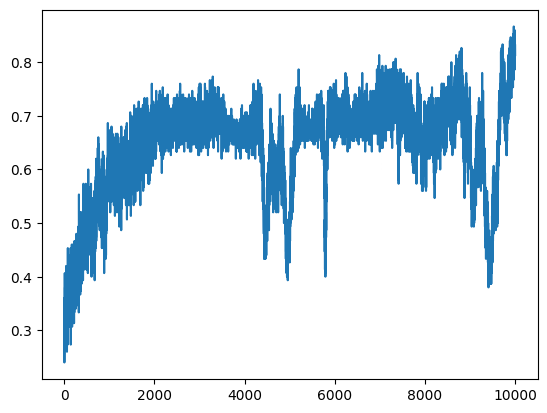

In [8]:
plt.plot(rewards);

# GRPO

In [129]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=16),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=16, out_features=16),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=16, out_features=3),
)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

rewards = []
baselines = []

num_epochs = 10000
for i in range(num_epochs):
    logits = net(x)
    probs = torch.softmax(logits, dim=-1)
    drawn_class = torch.multinomial(probs, num_samples=1).squeeze()
    reward = (drawn_class == y).float().mean().detach()

    log_probs = torch.log_softmax(logits, dim=-1)
    selected_log_probs = log_probs[torch.arange(len(drawn_class)), drawn_class]

    group_size = 64
    group = torch.multinomial(probs, num_samples=group_size, replacement=True)
    baseline = (group == y.unsqueeze(dim=-1)).float().mean().detach()
    loss = -((reward - baseline) * selected_log_probs).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    rewards.append(reward.mean().item())
    baselines.append(baseline.item())

rewards = torch.tensor(rewards)
rewards[:50].mean(), rewards[-50:].mean()

(tensor(0.3597), tensor(0.9780))

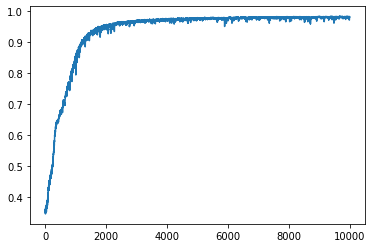

In [130]:
plt.plot(baselines)

Prof. mh remarks: the key is to reduce the variance and converge faster, both is acheived with a baseline computed from the average of the group.

## Gradient Descent on CE Loss (Sanity Check)

In [53]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=3),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=3, out_features=3),
    torch.nn.GELU(),
    torch.nn.Linear(in_features=3, out_features=4),
)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
accuracies = []
num_epochs = 1000
for i in range(num_epochs):

    logits = net(x)
    
    loss = criterion(logits, y)
    
    net.zero_grad()
    loss.backward()
    opt.step()    

    predicted = torch.argmax(logits, dim=1)
    accuracy = (predicted == y).float().mean()
    accuracies.append(accuracy.item())    

    if (i+1) % 100 == 0:
        print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch [100/1000], Loss: 1.1233, Accuracy: 0.3333
Epoch [200/1000], Loss: 0.9311, Accuracy: 0.3600
Epoch [300/1000], Loss: 0.7714, Accuracy: 0.7267
Epoch [400/1000], Loss: 0.6677, Accuracy: 0.7933
Epoch [500/1000], Loss: 0.5952, Accuracy: 0.8467
Epoch [600/1000], Loss: 0.5414, Accuracy: 0.8667
Epoch [700/1000], Loss: 0.4986, Accuracy: 0.8800
Epoch [800/1000], Loss: 0.4621, Accuracy: 0.9067
Epoch [900/1000], Loss: 0.4293, Accuracy: 0.9200
Epoch [1000/1000], Loss: 0.3989, Accuracy: 0.9600


## Background: PPO

Importance sampling: 

\begin{align}
&\int f(x)p(x)\ dx = E_p[f(x)]\\
=&\int f(x)p(x) \cdot 1\ dx\\
=&\int f(x)p(x) \cdot \frac{q(x)}{q(x)}\ dx\\
=&\int f(x)q(x) \cdot \frac{p(x)}{q(x)}\ dx = E_q\left[f(x)\frac{p(x)}{q(x)}\right]\\
\end{align}

$L(\theta) = \mathbb{E}_t \left[ \min \left( r_t A_t, \text{clip}(r_t, 1 - \epsilon, 1 + \epsilon) A_t \right) \right]$

Rewrite after looking into `grpo_loss` in [this file](https://github.com/aburkov/theLMbook/blob/main/GRPO.py).

| Symbol | Meaning |
| ---:| --- |
| $\phi$ | model weights |
| $x,y$ | model input (prompt) and sampled outputs |
| $r(x,y)$ | reward |
| $\pi_\phi^\text{RL}$ | policy (model) |

What we want to find / our objective:

\begin{align}
&\displaystyle \nabla_\phi E_{\pi_\phi^\text{RL}(x,y)}\left[r(x,y)\right]\\
=&\nabla_\phi\int r(x,y)\ \pi_\phi^\text{RL}(x,y)\ dxdy\\
=&\int r(x,y)\ \nabla_\phi \pi_\phi^\text{RL}(x,y)\ dxdy\\
=&\int r(x,y)\ \nabla_\phi \ln \pi_\phi^\text{RL}(x,y) \cdot \pi_\phi^\text{RL}(x,y)\ dxdy\\
\approx&\frac{1}{N}\sum_n^N r(x,y)\  \nabla_\phi \ln \pi_\phi^\text{RL}(x_n,y_n) & \text{with } (x_n,y_n) \sim \pi_\phi^\text{RL}(x,y)\\
\end{align}